In [8]:
!pip3 install earthpy

  Using cached earthpy-0.9.4-py3-none-any.whl (1.4 MB)
  Using cached rasterio-1.3.3.tar.gz (405 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      Error in sitecustomize; set PYTHONVERBOSE for traceback:
      AssertionError:
      ERROR: Cython.Build.cythonize not found. Cython is required to build rasterio.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [ ]:
# Mount Google Drive to the current Colab (only run when using colab)
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Import the necessary Python files (only run when using colab)
!cp /content/drive/MyDrive/GoForest/Counting-Trees-using-Satellite-Images/losses.py .
!cp /content/drive/MyDrive/GoForest/Counting-Trees-using-Satellite-Images/unet_model.py .
!cp /content/drive/MyDrive/GoForest/Counting-Trees-using-Satellite-Images/helper_functions.py .

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import earthpy.plot as ep
import numpy as np
from utils import *
from helper_functions import *
from unet_model import *
import sys
import os
import warnings
import datetime
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    
os.environ["CUDA_VISIBLE_DEVICES"]="0"

ModuleNotFoundError: No module named 'earthpy'

## 1. Load and Preprocess Dataset

In [5]:
from PIL import Image, ImageFile
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Can we also use regular .png files for the load_data function
import imageio

images_cut_path = '/content/drive/MyDrive/GoForest/yosemite-tree-dataset/images_cut'

X_DICT_TRAIN = dict()
Y_DICT_TRAIN = dict()
X_DICT_VALIDATION = dict()
Y_DICT_VALIDATION = dict()

amount_of_patches = len(os.listdir(images_cut_path))//2
for nr in tqdm(range(amount_of_patches)):
  data_img = np.asarray(PIL.Image.open(os.path.join(images_cut_path, f"{nr}_data.png")))
  label_img = np.asarray(PIL.Image.open(os.path.join(images_cut_path, f"{nr}_label.png")))
  train_xsz = int(3/4 * data_img.shape[0])
  X_DICT_TRAIN[str(nr).zfill(2)] = data_img[:train_xsz, :, :]
  Y_DICT_TRAIN[str(nr).zfill(2)] = label_img[:train_xsz, :]
  X_DICT_VALIDATION[str(nr).zfill(2)] = data_img[train_xsz:, :, :]
  Y_DICT_VALIDATION[str(nr).zfill(2)] = label_img[train_xsz:, :]

100%|██████████| 25/25 [01:17<00:00,  3.09s/it]


In [ ]:
# Reshape the arrays in Y_DICT_TRAIN and Y_DICT_VALIDATION from 2d to 3d
for key in Y_DICT_TRAIN.keys():
  Y_DICT_TRAIN[key] = Y_DICT_TRAIN[key].reshape(Y_DICT_TRAIN[key].shape[0], Y_DICT_TRAIN[key].shape[1], 1)
  Y_DICT_VALIDATION[key] = Y_DICT_VALIDATION[key].reshape(Y_DICT_VALIDATION[key].shape[0], Y_DICT_VALIDATION[key].shape[1], 1)

In [ ]:
plot_train_data(X_DICT_TRAIN, Y_DICT_TRAIN, image_number = 0)

In [25]:
np.any(Y_DICT_TRAIN['00'])

True

In [28]:
N_BANDS = 3
N_CLASSES = 1  # buildings, roads, trees, crops and water
N_EPOCHS = 10
PATCH_SZ = 160   # should divide by 16
BATCH_SIZE = 100
TRAIN_SZ = 5000  # train size
VAL_SZ = 500    # validation size
channel='all'#  0: Buildings , 1: Roads & Tracks, 2: Trees , 3: Crops, 4: Water or 'all'


In [59]:
x_train, y_train = get_patches(X_DICT_TRAIN, Y_DICT_TRAIN, n_patches=TRAIN_SZ, sz=PATCH_SZ, channel=channel)
x_val, y_val = get_patches(X_DICT_VALIDATION, Y_DICT_VALIDATION, n_patches=VAL_SZ, sz=PATCH_SZ, channel=channel)
#y_train = y_train[:,:, :,2:3]
#y_val = y_val[:,:, :,2:3]

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

Generated 5000 patches
Generated 500 patches


In [60]:
print("Train shape is: {} and Train Ground truth shape is: {}".format(x_train.shape, y_train.shape))
print("Validation shape is: {} and Validation Ground truth shape is: {}".format(x_val.shape, y_val.shape))

Train shape is: (5000, 160, 160, 3) and Train Ground truth shape is: (5000, 160, 160, 1)
Validation shape is: (500, 160, 160, 3) and Validation Ground truth shape is: (500, 160, 160, 1)


## 2. Build and Train  U-net Model

In [63]:
model = unet_model( n_classes= N_CLASSES,
                    im_sz= PATCH_SZ,
                    n_channels = N_BANDS,
                    n_filters_start = 32,
                    growth_factor = 2,
                    upconv=True)

In [ ]:
model.summary()

In [ ]:
callbacks_list = get_callbacks()

model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          verbose=1, shuffle=True, validation_data=(x_val, y_val), callbacks=callbacks_list)

Epoch 1/10


## 3. Load trained Model

In [ ]:
model_path = "/home/amir/Desktop/Tree Counting/Counting Trees/models/UNet_(11-26-2020 , 19:51:28)"

In [ ]:
model =  model_load(model_path)

## 4. Evaluate trained Model

In [ ]:
y_pred = model.predict(x_val)

In [ ]:
number = 123 #56 ,34
img = y_pred[number,:,:,:]

opened_img, number_of_objects, blob_labels = post_processing(img)
print("Number of Trees: {}".format(number_of_objects[-1]))

Number of Trees: 27


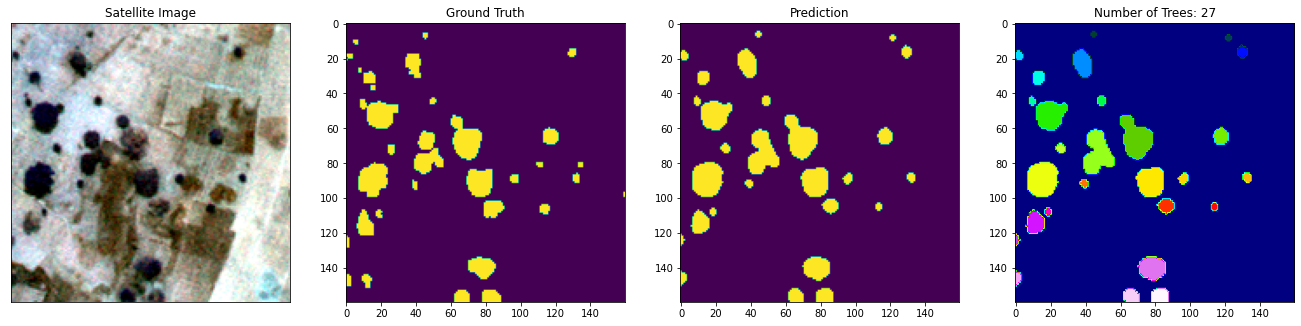

In [ ]:
f, axs = plt.subplots(1,4, figsize=(23,23))

ep.plot_rgb(x_val[number,:,:,:].transpose([2,0,1]),
            rgb=[0, 1, 2],
            title="Satellite Image",
            stretch=True,
            ax=axs[0])

axs[1].imshow(y_val[number,:,:,:])
axs[1].set_title("Ground Truth")

axs[2].imshow(opened_img)
axs[2].set_title("Prediction")


axs[3].imshow(blob_labels, cmap='gist_ncar')
axs[3].set_title("Number of Trees: {}".format(number_of_objects[-1]))

f.show()
